In [1]:
import numpy as np
import pandas as pd
import cloudpickle as pkl
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from xgboost import XGBClassifier
# from hyperopt import tpe, fmin, Trials, hp, STATUS_OK
# from hyperopt.pyll import scope
import matplotlib.pyplot as plt
import cloudpickle as pkl
from column_utils import *
from IPython.display import display, HTML, Image

import yaml
from pathlib import Path

In [2]:
target = 'gold'
model_date = '20241121'
version = 2
algo = 'xgb'

model_name = f'{target}_{algo}_{model_date}_v{version}'
with open(f'{target}/{model_name}/calibrated_model.pkl', 'rb') as model_file:
    model = pkl.load(model_file)

In [3]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

product_window = config['product_window'][target]
n_jobs = config['n_jobs']

## Import Model and Create OOT Validation data

In [4]:
date_range = ['2024-09-19', '2024-09-26']
data = pd.DataFrame()
model_folder = f'{target}'
for date in date_range:
    new_df = pd.read_csv(f'{target}/snapshots/model_base_{date}_{target}.csv')
    new_df['date'] = date
    data = pd.concat([data, new_df], ignore_index=True)
    print(new_df.shape)
    
data.shape

(969265, 224)
(899668, 224)


(1868933, 224)

In [5]:
columns = pd.read_csv(f'{target}/{model_name}/features.csv')['0'].to_list()
columns

['logins_count_last_1m',
 'avg_app_duration',
 'days_since_last_login',
 'waconsent',
 'homepage_gold_last_16days_to_1m',
 'homepage_personal_loan_last_1m',
 'experian_credit_score',
 'upi_inflow_amt_L1m',
 'upi_outflow_amt_L1m',
 'upi_inflow_cnt_L1m']

In [6]:
x_test = data.copy()
y_test = data['target'].copy()

In [7]:
if not product_window == 'skip':
    drop_columns = get_drop_column_list(target, product_window)
    if drop_columns == 'all':
        if target == 'payments':
            products = ['bbps', 'upi']
            x_test = x_test.loc[:, ~x_test.columns.str.contains(r'homepage_(' + '|'.join(products) + r')_', regex=True)]
    else:
        rename_columns = get_update_column_dict(target, product_window)
        x_test = x_test.drop(columns=drop_columns)
        x_test = x_test.rename(columns=rename_columns)

In [8]:
x_test = x_test[columns + ['date']]
x_test.shape

(1868933, 11)

In [9]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1868933 entries, 0 to 1868932
Data columns (total 11 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   logins_count_last_1m             int64  
 1   avg_app_duration                 float64
 2   days_since_last_login            int64  
 3   waconsent                        float64
 4   homepage_gold_last_16days_to_1m  float64
 5   homepage_personal_loan_last_1m   float64
 6   experian_credit_score            float64
 7   upi_inflow_amt_L1m               float64
 8   upi_outflow_amt_L1m              float64
 9   upi_inflow_cnt_L1m               float64
 10  date                             object 
dtypes: float64(8), int64(2), object(1)
memory usage: 156.8+ MB


## Evaluate Model Performance

In [10]:
for date in date_range:
    test_auc_scores = []
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    x_oot = x_test[x_test.date == date].reset_index(drop=True)
    y_oot = y_test[x_test.date == date].reset_index(drop=True)
    for train_index, test_index in sss.split(x_oot, y_oot):
        x_val, y_val = x_oot.loc[train_index, columns], y_oot.iloc[train_index]
        auc_score = roc_auc_score(y_val, model.predict_proba(x_val)[:, 1])
        test_auc_scores.append(auc_score)

    test_auc = np.mean(test_auc_scores)
    print(f"""
    OOT Gini for {date}:
        Fold 1: {2 * test_auc_scores[0] - 1:.2f}
        Fold 2: {2 * test_auc_scores[1] - 1:.2f}
        Fold 3: {2 * test_auc_scores[2] - 1:.2f}
        Fold 4: {2 * test_auc_scores[3] - 1:.2f}
        Fold 5: {2 * test_auc_scores[4] - 1:.2f}

    Average Gini = {2 * test_auc - 1:.2f}
    """)


    OOT Gini for 2024-09-19:
        Fold 1: 0.78
        Fold 2: 0.78
        Fold 3: 0.79
        Fold 4: 0.78
        Fold 5: 0.79

    Average Gini = 0.79
    

    OOT Gini for 2024-09-26:
        Fold 1: 0.78
        Fold 2: 0.78
        Fold 3: 0.79
        Fold 4: 0.79
        Fold 5: 0.78

    Average Gini = 0.78
    


In [11]:
for date in date_range:
    x_oot = x_test[x_test.date == date][columns].reset_index(drop=True)
    y_oot = y_test[x_test.date == date].reset_index(drop=True)
    y_pred_proba = model.predict_proba(x_oot)[:, 1]
    deciles = pd.qcut(pd.Series(y_pred_proba).rank(method='first'), q=10, labels=False) + 1
    deciles_df = pd.DataFrame({
        'Probability': y_pred_proba,
        'Actual': y_oot,
        'Decile': deciles,
        'Bin Size': 1
    }).sort_values(['Decile', 'Probability'],ascending=False)

    agg_deciles_df = deciles_df.groupby('Decile').agg({
        'Probability': ['mean', 'nunique'],
        'Actual':'sum',
        'Bin Size': 'sum'
    }).reset_index().sort_values(['Decile'], ascending=False)
    agg_deciles_df['Actual'] = agg_deciles_df.pop('Actual')

    agg_deciles_df['response_rate'] = agg_deciles_df['Actual'] / y_test.shape[0]
    agg_deciles_df['decile_recall'] = agg_deciles_df['Actual'] / y_test.sum()
    agg_deciles_df['capture_rate'] = agg_deciles_df['Actual'].cumsum() * 100 / y_test.sum()
    agg_deciles_df['Bin Size'] = agg_deciles_df.pop('Bin Size')
    display(HTML(f"<h3>Decile Analysis for {date}</h3>{agg_deciles_df.to_html(index=False)}"))

In [12]:
average_event_rate = y_test.sum() / y_test.shape[0]
f"{average_event_rate * 100 :.2f}%"

'0.17%'

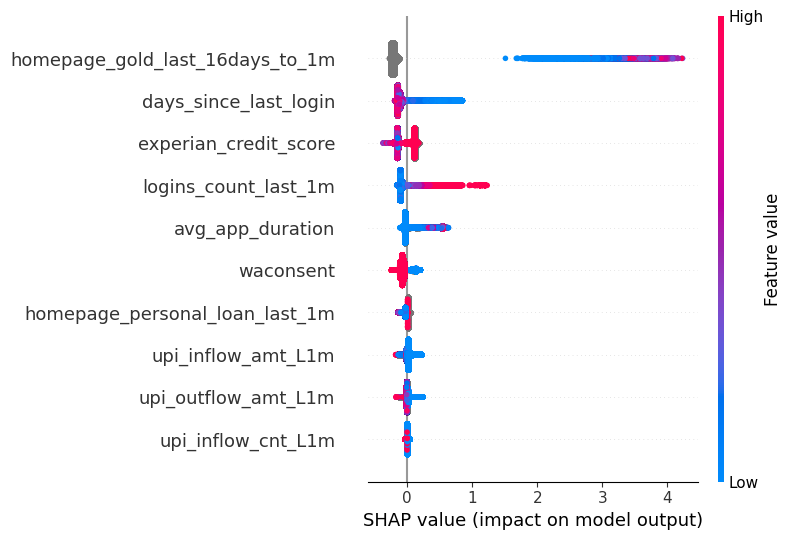

In [15]:
explainer = shap.TreeExplainer(model.estimator)
shap_values = explainer.shap_values(x_test[columns])
shap.summary_plot(shap_values, x_test[columns])

In [16]:
x_test.isnull().sum(axis=0) / x_test.shape[0]

logins_count_last_1m               0.000000
avg_app_duration                   0.182323
days_since_last_login              0.000000
waconsent                          0.000081
homepage_gold_last_16days_to_1m    0.991826
homepage_personal_loan_last_1m     0.671474
experian_credit_score              0.375247
upi_inflow_amt_L1m                 0.093343
upi_outflow_amt_L1m                0.093343
upi_inflow_cnt_L1m                 0.093343
date                               0.000000
dtype: float64